## Gesture Kinematic Analysis

In this tutorial, we learn how to compute the kinematic features (speed, velocity, acceleration and jerk) for gestures using Mediapipe keypoints.

## Script Overview

 - Import necessary packages
 - Read saved Mediapipe keypoints 
 - Normalise the keypoints
 - Perform smoothing
 - Extract the speed, velocity, acceleration, and jerk
 - Visualise the kinematic measures

Citation: Pouw, W. (2023). Selecting, smoothing, and deriving measures from motion tracking, and merging with acoustics and annotations. Retrieved from: https://envisionbox.org/embedded_MergingMultimodal_inPython.html

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go
from scipy.signal import butter, filtfilt

from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
data = pd.read_csv('sample1_body.csv')
data.head()

,time,X_NOSE,Y_NOSE,Z_NOSE,visibility_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,visibility_LEFT_EYE_INNER,X_LEFT_EYE,...,Z_RIGHT_HEEL,visibility_RIGHT_HEEL,X_LEFT_FOOT_INDEX,Y_LEFT_FOOT_INDEX,Z_LEFT_FOOT_INDEX,visibility_LEFT_FOOT_INDEX,X_RIGHT_FOOT_INDEX,Y_RIGHT_FOOT_INDEX,Z_RIGHT_FOOT_INDEX,visibility_RIGHT_FOOT_INDEX
0,0.0000,0.542872,0.320528,-0.599554,0.999864,0.548028,0.272748,-0.571874,0.999773,0.553795,...,0.784758,0.000123,0.518054,1.825048,0.221179,0.000053,0.413529,1.813922,0.530369,0.000261
1,33.3667,0.537859,0.305708,-0.716547,0.999894,0.545356,0.267199,-0.690076,0.999839,0.551510,...,0.746904,0.000205,0.499054,1.930795,0.191816,0.000077,0.394042,1.916830,0.457570,0.000360
2,66.7334,0.529832,0.305883,-0.687621,0.999892,0.539449,0.266203,-0.658586,0.999865,0.547077,...,0.813804,0.000133,0.519656,1.956075,0.188116,0.000062,0.411439,1.953299,0.506572,0.000301
3,100.1001,0.523688,0.309514,-0.638879,0.999880,0.536462,0.262996,-0.604539,0.999773,0.543984,...,0.610559,0.000052,0.528164,2.064853,0.089942,0.000038,0.418676,2.063022,0.253502,0.000205
4,133.4668,0.523353,0.309790,-0.639716,0.999872,0.536411,0.263409,-0.605194,0.999761,0.544014,...,0.605660,0.000052,0.528871,2.067966,0.091081,0.000035,0.418544,2.066678,0.246125,0.000202


## Normalisation 


Normalization of keypoints is important for ensuring a consistent representation of poses across different frames and individuals. Moreover, it addresses the potential variance in the actual position of a person in the image, directing the pose representation to emphasize the relative positions of body parts rather than their absolute positions.


The following code normalizes a set of keypoints representing a skeleton by centering them around the mean position between the left and right shoulders and scaling them based on the distance between these shoulders. 

In [3]:
def normalize_skeleton_landmarks(keypoints):
    left_shoulder, right_shoulder = 11, 12  # Assuming the indices for left and right shoulder in markersbody
    mid = keypoints[:, [left_shoulder, right_shoulder], :].mean(axis=1, keepdims=True)

    shoulder_length = np.linalg.norm(keypoints[:, left_shoulder, :] - keypoints[:, right_shoulder, :], ord=2, axis=1)
    normalized_keypts = (keypoints - mid) / shoulder_length[:, None, None]
    return normalized_keypts

In [4]:
markersbody = ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER',
          'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 
          'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
          'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE',
          'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']

xyz_columns = [axis + '_' + landmark  for landmark in markersbody for axis in ['X', 'Y', 'Z']]


# Select only the columns representing X, Y, Z coordinates
keypoints_columns = data[xyz_columns]


# Take the absolute value of Z coordinates
z_columns = [col for col in keypoints_columns.columns if col.startswith('Z_')]

# Reshape the data into the required format (num_frames, num_keypoints, 3)
num_keypoints = len(xyz_columns) // 3
keypoints_array = keypoints_columns.values.reshape(-1, num_keypoints, 3)

# Apply normalization function
normalized_keypoints = normalize_skeleton_landmarks(keypoints_array)

# Update the DataFrame with the normalized values
normalized_keypoints_df = pd.DataFrame(normalized_keypoints.reshape(-1, num_keypoints * 3), columns=xyz_columns)


## Data Visualisation

In [5]:
def getSkeletalModelStructure():
    # Definition of skeleton model structure:
    # The structure is an n-tuple of:
    # (index of a start point, index of an end point, index of a bone)

    return (
        # nose
        (0, 1, 0),
        (0, 4, 0),

        # eyes
        (1, 2, 1),
        (2, 3, 1),
        (4, 5, 1),
        (5, 6, 1),

        # ears
        (6, 8, 2),
        (3, 7, 2),

        # mouth
        (9, 10, 3),

        # collar bone
        (11, 12, 4),
        (12, 24, 4),
        (11, 23, 4),
        (24, 23, 4),
        (24, 26, 4),
        (23, 25, 4),
        (26, 28, 4),
        (25, 27, 4),
        (28, 30, 4),
        (30, 32, 4),
        (28, 32, 4),
        (27, 31, 4),
        (27, 29, 4),
        (29, 31, 4),

        # arms
        (12, 14, 5),
        (11, 13, 5),

        # hands
        (13, 15, 6),
        (14, 16, 6),

        # fingers
        (15, 21, 7),
        (15, 17, 7),
        (15, 19, 7),
        (17, 19, 7),
        (16, 18, 7),
        (16, 22, 7),
        (16, 20, 7),
        (18, 20, 7)
    )

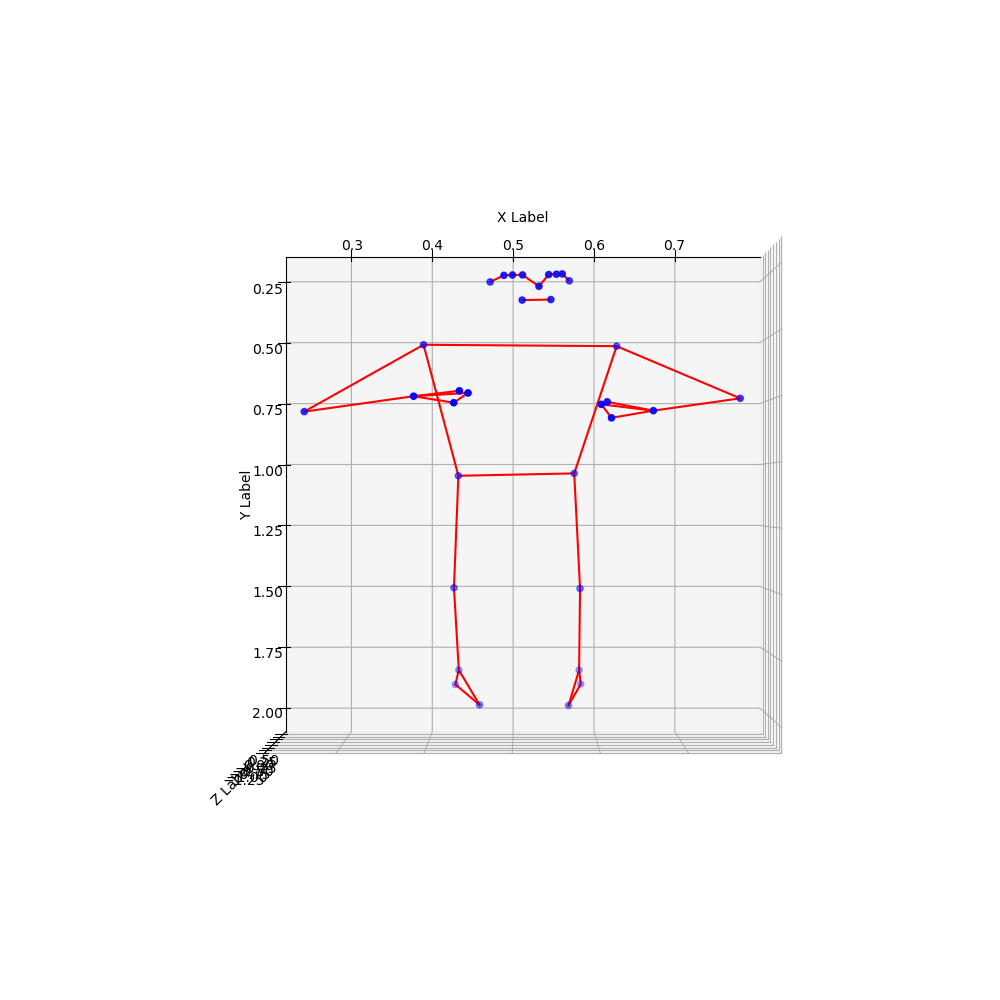

In [7]:

def plot_3d_skeleton(keypoints, skeletal_model_structure, ax, color):

#     Extract x, y, z coordinates
    x, y, z = zip(*keypoints)

    # Plot keypoints
    ax.scatter(x, y, z, color='blue', label='Keypoints')
    ax.view_init(elev=-90, azim=-90)
    # Plot skeleton connections
    for connection in skeletal_model_structure:
        start_idx, end_idx, _ = connection
        start_point = keypoints[start_idx]
        end_point = keypoints[end_idx]
        xs = [start_point[0], end_point[0]]
        ys = [start_point[1], end_point[1]]
        zs = [start_point[2], end_point[2]]
        ax.plot(xs, ys, zs, color=color)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()



# Assuming you have keypoints and skeletal_model_structure

skeletal_model_structure = getSkeletalModelStructure()  # Use the corrected function

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot the 3D skeleton
plot_3d_skeleton(keypoints_array[20], skeletal_model_structure, ax, color='red')

# plt.show()



In [7]:
data.update(normalized_keypoints_df)

## Smoothing


One thing that you will run into when using motion tracking data, especially when using video based motion tracking data, is that you will have noise-related jitter in your time series. At some times such noise maybe minimal, e.g., when using very accurate device-based motion tracking devices. But in other cases, you will see that there are sudden jumps or kinks from time point to time point due to tracking inaccuracies (that can be caused by occlusions, or not ideal lighting, camara position changes, etc.).

It is good therefore to apply some smoothing to the position traces of your motion tracking data, as well as any derivatives that are approximated afterwards (e.g., 3D speed, vertical velocity). You can for example apply a low-pass filter, whereby you try to only allow fluctuations that have a slow frequency change (gradual changes from point to point) so as to filter out (i.e., reduce the amplitude of) the jitter that occurs at very high frequencies (because they result in sudden changes from point to point). Note that when using low-pass filters there can be some time shift, so in that case it is good to undo that shift by running the smoothing forwards and backwards (we do this by using filtfilt); this undoing of distortions in time is called a “zero-phase” low-pass filter. Applying zero-phase low-pass filters is important if you care about precise temporal precision relative to some other timeseries for example (e.g., acoustics).

In [8]:
def butter_it(x, sampling_rate, order, lowpass_cutoff):
    nyquist = sampling_rate / 2
    cutoff = lowpass_cutoff / nyquist  # Normalized frequency
    b, a = butter(order, cutoff, btype='low')
    filtered_x = filtfilt(b, a, x)
    return np.asarray(filtered_x, dtype=np.float64)

In [9]:
#apply a butterworth filter to the following position traces

data[xyz_columns] = data[xyz_columns].apply(lambda x: butter_it(x=x,sampling_rate=100, order=20, lowpass_cutoff=20))

## Kinematic Measures
<b> Speed </b> : Change in distance per unit time

<b>  Velocity </b> : Change in displacement per unit time

<b> Acceleration </b> : Change in velocity per unit time

<b> Jerk </b> : Change in acceleration per unit time

In [16]:
# function that differientates and butterworth filters the speed vector
def derive_it(x):
    x = np.concatenate(([0], np.diff(x)))
    x= butter_it(x, sampling_rate=100, order=2, lowpass_cutoff=20)
    return x

# function to calculate the speed vector
def get_speed_vector(x, y, z, time_millisecond):
#     z = abs(z)
    # calculate the Euclidean distance from time point x to time point x+1, for 3 dimensions
    speed = np.concatenate(([0], np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2 + np.diff(z) ** 2)))
    speed = butter_it(speed, sampling_rate=100, order=2, lowpass_cutoff=20)

    # scale the speed vector so that we express it units change per second change
    time_diff = np.mean(np.diff(time_millisecond)) / 1000
    speed = speed / time_diff
    return speed

# function to scale the time series
def sc_it(x):
    return (x - np.mean(x)) / np.std(x, ddof=0)

#make a new variable in a pandas dataframe
data['speed'] = get_speed_vector(data['X_RIGHT_INDEX'], data['Y_RIGHT_INDEX'], data['Z_RIGHT_INDEX'], data['time'])
data['vertical_velocity'] = derive_it(data['Y_RIGHT_INDEX'])/np.mean(np.diff(data['time']))
data['acceleration'] = derive_it(data['speed'])
data['jerk'] = derive_it(data['acceleration'])

# cs = ['speed', 'vertical_velocity', 'acceleration', 'jerk']
# data[cs] = data[cs].apply(lambda x: sc_it(x)) #to ensure that the different features are on a similar scale


# Create the plot using Plotly Express (px)
# Create the second plot
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=data['time'], y=data['speed'], name='speed', mode='lines', line=dict(color='black')))
fig4.add_trace(go.Scatter(x=data['time'], y=data['vertical_velocity'], name='vertical velocity', mode='lines', line=dict(color='red')))
fig4.add_trace(go.Scatter(x=data['time'], y=data['acceleration'], name='acceleration', mode='lines', line=dict(color='gold')))
fig4.add_trace(go.Scatter(x=data['time'], y=data['jerk'], name='jerk', mode='lines', line=dict(color='green')))
# show only a portion of the plot for the x axis
fig4.update_xaxes(range=[1800, 2600])
fig4.show()